# P3: Using Cartopy for mapping 
## Using cartopy for mapping (STANDAN021)

In [3]:
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader


# Figure 1: Antarctic Continent and Southern Ocean
## Projection: South Polar Stereo
This figure displays the Antarctic continent and the Southern Ocean starting from 60°S. The South Polar Stereo projection is chosen because this is generally the right projection used for polar regions, such as Antartica and the surrounding ocean environment. It is the most accurate projection that is able to preserve the angles and shapes at a very small scale, this is helpful when completing detailed studies in the Antarctic region that use geospatial analyses to glacial changes and sea ice movement. Furthermore, ocean currents along with sea ice drifts are able to be tracked using the circles of latitude that appear as concentric circles. 

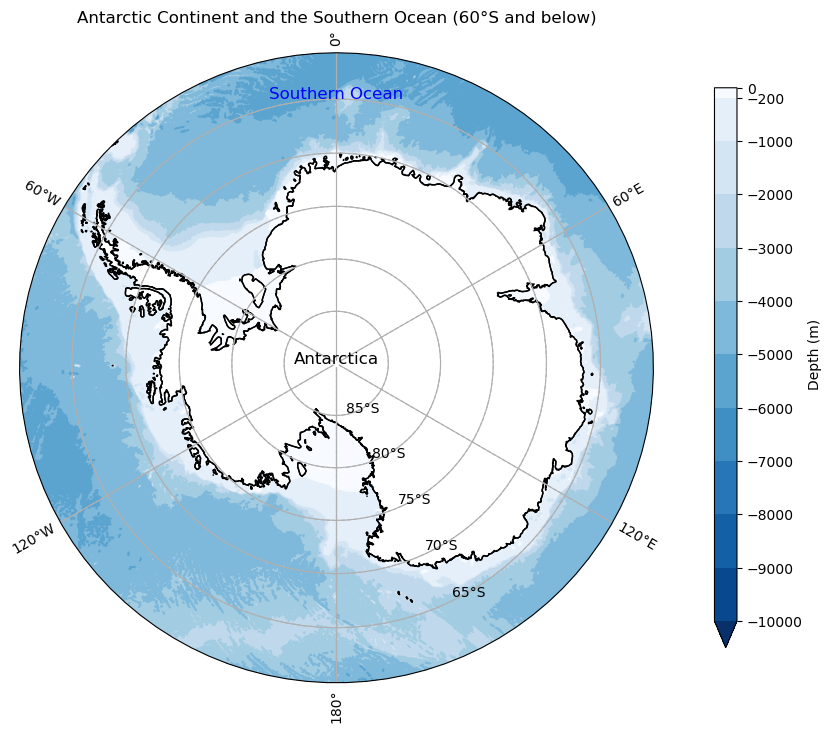

In [4]:
def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile

    import requests
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("ne_10m_bathymetry_all/")

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob('ne_10m_bathymetry_all/*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (-180, -90, 180, -60)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict


if __name__ == "__main__":
    # Load data (14.8 MB file)
    depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')

    # Construct a discrete colormap with colors corresponding to each depth
    depths = depths_str.astype(int)
    N = len(depths)
    nudge = 0.01  # shift bin edge slightly to include data
    boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
    norm = matplotlib.colors.BoundaryNorm(boundaries, N)
    blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
    colors_depths = blues_cm(norm(depths))

    # Set up plot
    subplot_kw = {'projection': ccrs.SouthPolarStereo()}
    fig, ax = plt.subplots(subplot_kw=subplot_kw, figsize=(9, 7))
    ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())  # x0, x1, y0, y1

    # Iterate and plot feature for each depth level
    for i, depth_str in enumerate(depths_str):
        ax.add_geometries(shp_dict[depth_str].geometries(),
                          crs=ccrs.PlateCarree(),
                          color=colors_depths[i])

    # Add standard features
    ax.add_feature(cfeature.LAND, color='white')
    ax.coastlines(lw=1, resolution='10m')
    ax.gridlines(draw_labels=False)
    ax.set_position([0.03, 0.05, 0.8, 0.9])

    # Add custom colorbar
    axi = fig.add_axes([0.85, 0.1, 0.025, 0.8])
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    sm = plt.cm.ScalarMappable(cmap=blues_cm, norm=norm)
    fig.colorbar(mappable=sm,
                 cax=axi,
                 spacing='proportional',
                 extend='min',
                 ticks=depths,
                 label='Depth (m)')

    # Convert vector bathymetries to raster (saves a lot of disk space)
    # while leaving labels as vectors
    ax.set_rasterized(True)

ax.gridlines(draw_labels=True, linestyle='--')
ax.set_title("Antarctic Continent and the Southern Ocean (60°S and below)")
ax.text(0, -65, "Southern Ocean", transform=ccrs.PlateCarree(), fontsize=12, color='blue', ha='center')
ax.text(0, -90, "Antarctica", transform=ccrs.PlateCarree(), fontsize=12, color='black', ha='center')
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.coastlines()



ax.set_boundary(circle, transform=ax.transAxes)
plt.show()

# Figure 2: The South Atlantic (from 20°S to 50°S)
## Projection: PlateCarree
### This map covers the South Atlantic region from 20°S to 50°S, highlighting key coastal locations: Walvis Bay, Cape Town, Rio de Janeiro, and Montevideo. The PlateCaree is a useful projection in this case, as it maps the longitute (long) and latitude (lat) to a Cartesian grid, as each degree is evenly spaced, this makes for the raw geospatial data to be intuitively overlayed without any additional transformations. Furthermore, this is projection is beneficial when dealing with many datasets such as sea surface temeprature models; the ARGO float data and ocean current maps. 

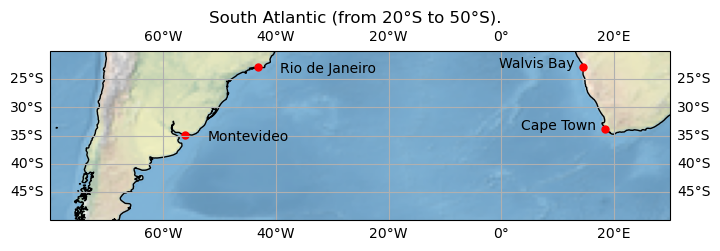

In [5]:
# 2. South Atlantic with Key Locations
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-80, 30, -50, -20], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Adding key locations
cities = {"Walvis Bay": (14.5, -22.9), "Cape Town": (18.4, -33.9),
          "Rio de Janeiro": (-43.2, -22.9), "Montevideo": (-56.2, -34.9)}

for city, (lon, lat) in cities.items():
    ax.plot(lon, lat, marker="o", color="red", markersize=5, transform=ccrs.PlateCarree())
    if city == "Rio de Janeiro" or city == "Montevideo": 
        ax.text(lon + 4, lat - 1, city, fontsize=10, transform=ccrs.PlateCarree())
    else:
        ax.text(lon - 15, lat, city, fontsize=10, transform=ccrs.PlateCarree())

ax.gridlines(draw_labels=True)
ax.stock_img()
plt.title("South Atlantic (from 20°S to 50°S).  ")
plt.show()

# 3. False Bay Coastline Resolution Comparison from the GSHHG database
## Projection: PlateCarree
### Description: This figure illustrates the coastline resolution comparison for False Bay, South Africa, using three different levels of detail from the GSHHG database.This visualization demonstrates how different levels of resolution affect the clarity and precision of coastal mapping. The PlateCarree projection was used for this figure, it also preserves a simple latitude-longitude grid, which overall makes it easy to compare and overlay geographic data without distortion. Considering that False is a relatively small area, it is uneccessary to use a projection such as the sterographic one as that may attribute to unwanted distortions in the data. The different resolutions are made more visible withought affecting their spatial relationships. 

C:\Users\STNDAN021\AppData\Local\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhs/latest/gshhg-shp-2.3.7.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


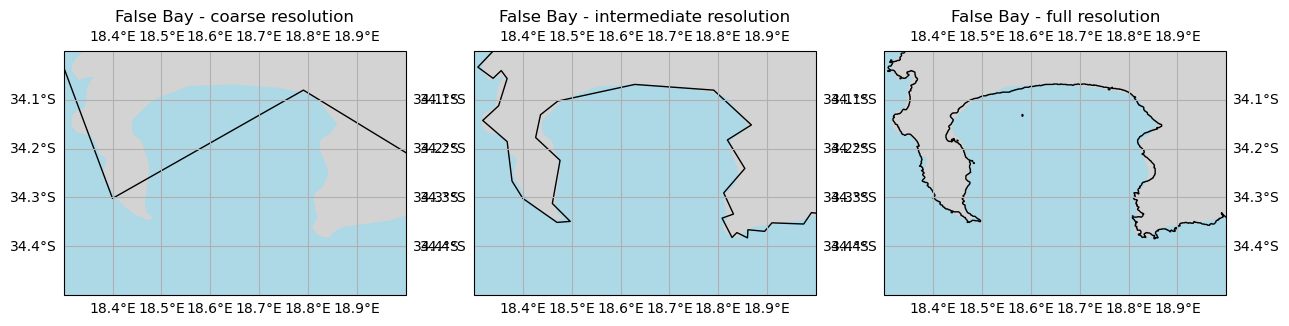

In [6]:
# 3. False Bay Coastline Resolution Comparison
resolutions = ['coarse', 'intermediate', 'full']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, res in zip(axes, resolutions):
    ax.set_extent([18.3, 19, -34, -34.5], crs=ccrs.PlateCarree())
    #ax.add_feature(cfeature.LAND, color='lightgray')
    gshhs_coast = cfeature.GSHHSFeature(scale=res, levels=[1], edgecolor='black')
    ax.add_feature(gshhs_coast, linewidth=1)
    ax.gridlines(draw_labels=True)
    ax.set_title(f"False Bay - {res} resolution")
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
plt.show()